## Module 2 Homework

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.

In [ ]:
# IMPORTS
import pandas as pd
import requests
from io import StringIO

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

import matplotlib.pyplot as plt
import datetime

---
### Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

#### Steps:
1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 
2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Holdings” → `Holdings`
   - “Ltd” or “Limited” → `Ltd`
   - Others → `Other`

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`
4. Convert `Shares Offered` to numeric, clean missing or invalid values.
5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)
6. Group by `Company Class` and calculate total withdrawn value.
7. **Answer**: Which class had the highest **total** value of withdrawals?

**Load table**

In [9]:
def get_withdrawn_ipos() -> pd.DataFrame:
    """
    Fetch IPO data for withdrawn IPOs from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/withdrawn/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

df_withdrawn_ipos = get_withdrawn_ipos()
df_withdrawn_ipos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


🚨 100 entries!

In [71]:
pd.set_option('display.max_rows', 50)

**Classify companies – add a Company Class column using patterns**

In [72]:
def classify(name):
    name = name.replace(',', '').replace('.', '')
    n = name.lower().split()
    if "acquisition" in n and ("corp" in n or "corporation" in n):
        return "Acq.Corp"
    if "inc" in n or "incorporated" in n:
        return "Inc"
    if "group" in n:
        return "Group"
    if "holdings" in n:
        return "Holdings"
    if "ltd" in n or "limited" in n:
        return "Ltd"
    return "Other"

df_withdrawn_ipos['Company Class'] = df_withdrawn_ipos['Company Name'].apply(classify)

In [73]:
df_withdrawn_ipos

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg Price,Withdrawn Value
0,ODTX,"Odyssey Therapeutics, Inc.",-,NaN,Inc,NaN,NaN
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Inc,3.5,7000000.0
2,AURN,"Aurion Biotech, Inc.",-,NaN,Inc,NaN,NaN
3,ROTR,"PHI Group, Inc.",-,NaN,Inc,NaN,NaN
4,ONE,One Power Company,-,NaN,Other,NaN,NaN
...,...,...,...,...,...,...,...
95,FHP,"Freehold Properties, Inc.",-,NaN,Inc,NaN,NaN
96,CHO,Chobani Inc.,-,NaN,Inc,NaN,NaN
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231.0,Inc,19.5,600000004.5
98,GLGX,"Gerson Lehrman Group, Inc.",-,NaN,Inc,NaN,NaN


🚨 multiple COMPANY CLASS

<Axes: >

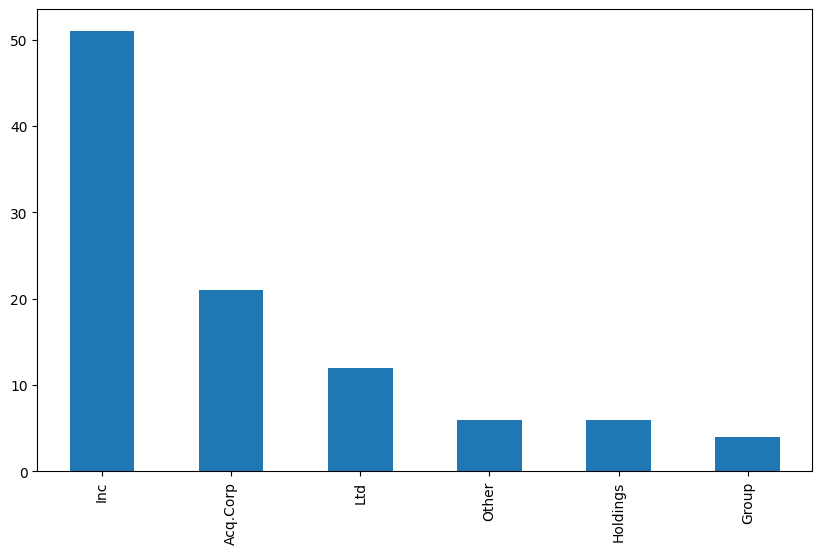

In [66]:
df_withdrawn_ipos['Company Class'].value_counts().plot(kind='bar', figsize=(10, 6))

**Compute average price – parse Price Range**

In [67]:
def avg_price(pr):
    if pd.isna(pr) or pr.strip() == "-":
        return np.nan
    parts = pr.replace('$','').split('-')
    try:
        return float(parts[0]) if len(parts)==1 else (float(parts[0])+float(parts[1]))/2
    except:
        return np.nan
    
df_withdrawn_ipos['Avg Price'] = df_withdrawn_ipos['Price Range'].apply(avg_price)
df_withdrawn_ipos[['Price Range', 'Avg Price']].tail(20)

,Price Range,Avg Price
80,-,NaN
81,$10.00,10.0
82,$10.00,10.0
83,-,NaN
84,$10.00,10.0
85,-,NaN
86,$13.00 - $15.00,14.0
87,$10.00,10.0
88,$10.00,10.0
89,-,NaN


**Clean shares and compute withdrawal value**

In [68]:
df_withdrawn_ipos['Shares Offered'] = pd.to_numeric(df_withdrawn_ipos['Shares Offered'], errors='coerce')
df_withdrawn_ipos['Withdrawn Value'] = df_withdrawn_ipos['Shares Offered'] * df_withdrawn_ipos['Avg Price']

In [69]:
df_withdrawn_ipos['Withdrawn Value'].notnull().sum()

71

In [70]:
total_by_class = df_withdrawn_ipos.groupby('Company Class')['Withdrawn Value'].sum().sort_values(ascending=False)
print(total_by_class)

Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         3.217346e+08
Holdings    3.030000e+08
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64


---
### Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.


#### Steps:

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.


3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.

5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?


**Get IPO list from StockAnalysis**

In [74]:
def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [88]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.columns = ipos_2024.columns.str.strip().str.replace(' ', '_').str.lower()
ipos_2024['ipo_date'] = pd.to_datetime(ipos_2024['ipo_date'])
ipos_2024_may = ipos_2024[ipos_2024.ipo_date < datetime.datetime(2024, 6, 1)].reset_index(drop=True)

In [90]:
ipos_2024_may['symbol']

0     NAKA
1      BOW
2      HDL
3     RFAI
4     JDZG
      ... 
72    CCTG
73    PSBD
74    SYNX
75    SDHC
76    ROMA
Name: symbol, Length: 77, dtype: object